### 1.按公司文件分开训练模型

GPU 可用，使用 GPU 加速
Epoch 1/100, Validation Loss: 0.13242672011256218
Epoch 2/100, Validation Loss: 0.0054781329818069935
Epoch 3/100, Validation Loss: 0.012309256242588162
Epoch 4/100, Validation Loss: 0.026828916743397713
Epoch 5/100, Validation Loss: 0.012047766242176294
Epoch 6/100, Validation Loss: 0.006180228898301721
Epoch 7/100, Validation Loss: 0.005200437735766172
Epoch 8/100, Validation Loss: 0.010562922805547714
Epoch 9/100, Validation Loss: 0.010405075270682573
Epoch 10/100, Validation Loss: 0.007741317385807633
Epoch 11/100, Validation Loss: 0.005076719564385712
Epoch 12/100, Validation Loss: 0.006985418498516083
Epoch 13/100, Validation Loss: 0.00613713264465332
Epoch 14/100, Validation Loss: 0.006771517917513847
Epoch 15/100, Validation Loss: 0.0064020908903330564
Epoch 16/100, Validation Loss: 0.005311955348588526
Epoch 17/100, Validation Loss: 0.004652010044082999
Epoch 18/100, Validation Loss: 0.005724503193050623
Epoch 19/100, Validation Loss: 0.0061236158944666386
Epo

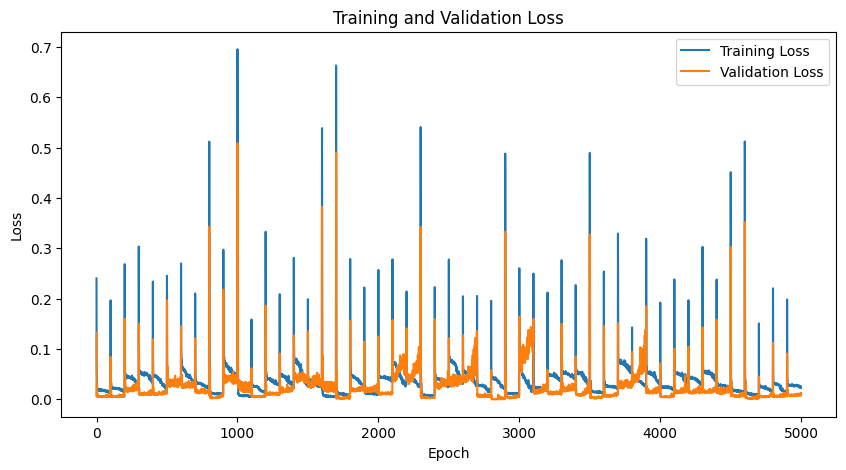

000001.SZ_平安银行_all2.xlsx: MAE=0.08558554202318192, MSE=0.011355049908161163, R2=-1.2862540189604688
000002.SZ_万科A_all2.xlsx: MAE=0.32496368885040283, MSE=0.146417498588562, R2=-1.8201735491927926
000063.SZ_中兴通讯_all2.xlsx: MAE=0.08550373464822769, MSE=0.010973009280860424, R2=-0.23575149546166219
000100.SZ_TCL科技_all2.xlsx: MAE=0.09951076656579971, MSE=0.019255690276622772, R2=-0.062432692320453675
000157.SZ_中联重科_all2.xlsx: MAE=0.09216316789388657, MSE=0.01649387739598751, R2=0.03940090017413944
000166.SZ_申万宏源_all2.xlsx: MAE=0.12277165055274963, MSE=0.025905916467308998, R2=-0.5465467374024444
000301.SZ_东方盛虹_all2.xlsx: MAE=0.2350921630859375, MSE=0.06703320145606995, R2=-3.1732641399025914
000333.SZ_美的集团_all2.xlsx: MAE=0.10976370424032211, MSE=0.021274790167808533, R2=-0.11006683460196265
000338.SZ_潍柴动力_all2.xlsx: MAE=0.0944497212767601, MSE=0.009946539998054504, R2=-8.474458704146484
000408.SZ_藏格矿业_all2.xlsx: MAE=0.3242892324924469, MSE=0.13999827206134796, R2=-7.752204068865305
000425.

RuntimeError: Parent directory E:/2412毕业论文/0104模型构建 does not exist.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import torch.nn.functional as F


def create_sequences(input_data, target_data, seq_length):
    """
    创建时间序列数据窗口
    :param input_data: 输入数据
    :param target_data: 目标数据
    :param seq_length: 时间序列长度
    :return: 序列输入和序列目标
    """
    sequences_x = []
    sequences_y = []
    for i in range(len(input_data) - seq_length):
        sequences_x.append(input_data[i:i + seq_length])
        sequences_y.append(target_data[i + seq_length])
    return np.array(sequences_x), np.array(sequences_y)


def load_and_preprocess_data(file_path):
    """
    加载并预处理数据
    :param file_path: 文件路径
    :return: 预处理后的序列数据
    """
    skip_column_names = ['所属申万行业名称(2014)_[行业级别]一级行业', '股票收益率1']
    all_columns = pd.read_excel(file_path, nrows=0).columns
    columns_to_use = [col for col in all_columns if col not in skip_column_names]
    data = pd.read_excel(file_path, usecols=columns_to_use)
    data = data.iloc[7:, 1:]
    x = data.iloc[:, 3:11].values
    y = data.iloc[:, -5].values
    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()
    x_scaled = scaler_x.fit_transform(x)
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))
    return x_scaled, y_scaled


def train_and_evaluate_model(model, train_loader, val_loader, test_loader, num_epochs, learning_rate, device):
    """
    训练和评估模型
    :param model: 模型
    :param train_loader: 训练数据加载器
    :param val_loader: 验证数据加载器
    :param test_loader: 测试数据加载器
    :param num_epochs: 训练轮数
    :param learning_rate: 学习率
    :param device: 运行设备
    :return: 训练损失列表，验证损失列表，测试集上的 MAE, MSE, R2 指标
    """
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()
        train_losses.append(epoch_train_loss / len(train_loader))
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                val_loss += criterion(outputs, targets).item()
        val_losses.append(val_loss / len(val_loader))
        print(f'Epoch {epoch + 1}/{num_epochs}, Validation Loss: {val_loss / len(val_loader)}')
    model.eval()
    test_loss = 0
    test_predictions = []
    test_targets = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            test_loss += criterion(outputs, targets).item()
            test_predictions.extend(outputs.cpu().numpy().flatten())
            test_targets.extend(targets.cpu().numpy().flatten())
    test_loss /= len(test_loader)
    mae = mean_absolute_error(test_targets, test_predictions)
    mse = mean_squared_error(test_targets, test_predictions)
    r2 = r2_score(test_targets, test_predictions)
    return train_losses, val_losses, mae, mse, r2


class ComplexModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(ComplexModel, self).__init__()
        self.conv1 = nn.Conv1d(input_size, 64, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.2)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.2)
        self.pool = nn.MaxPool1d(2)
        self.bilstm = nn.LSTM(128, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.attention = Attention(hidden_size * 2)
        self.fc1 = nn.Linear(hidden_size * 2, 256)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(256, output_size)


    def forward(self, x):
        x = x.permute(0, 2, 1)  
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.pool(x)
        x = x.permute(0, 2, 1)  
        out, _ = self.bilstm(x)
        out = self.attention(out)
        out = self.fc1(out)
        out = self.relu3(out)
        out = self.dropout3(out)
        out = self.fc2(out)
        return out


class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.attn = nn.Linear(hidden_size, 1)


    def forward(self, lstm_output):
        attn_weights = F.softmax(self.attn(lstm_output), dim=1)
        context_vector = torch.sum(attn_weights * lstm_output, dim=1)
        return context_vector


def main():
    folder_path = 'E:/2412毕业论文/0104数据特征/wind250109/0109沪深300股票1/处理2/处理'
    time_windows = 10
    num_epochs = 100
    learning_rate = 0.001
    input_size = 8  
    hidden_size = 50
    num_layers = 2
    output_size = 1



    if torch.cuda.is_available():
        device = torch.device("cuda:0")  
        print("GPU 可用，使用 GPU 加速")
    else:
        device = torch.device("cpu")
        print("GPU 不可用，使用 CPU")


    all_train_losses = []
    all_val_losses = []
    all_mae = []
    all_mse = []
    all_r2 = []


    for file in os.listdir(folder_path):
        if file.endswith('.xlsx'):
            file_path = os.path.join(folder_path, file)
            x_scaled, y_scaled = load_and_preprocess_data(file_path)
            sequences_x, sequences_y = create_sequences(x_scaled, y_scaled, time_windows)
            sequences_x = torch.FloatTensor(sequences_x).to(device)
            sequences_y = torch.FloatTensor(sequences_y).to(device)
            train_size = int(0.7 * len(sequences_x))
            val_size = int(0.2 * len(sequences_x))
            test_size = len(sequences_x) - train_size - val_size
            train_x = sequences_x[:train_size]
            train_y = sequences_y[:train_size]
            val_x = sequences_x[train_size:train_size + val_size]
            val_y = sequences_y[train_size:train_size + val_size]
            test_x = sequences_x[train_size + val_size:]
            test_y = sequences_y[train_size + val_size:]
            train_dataset = TensorDataset(train_x, train_y)
            val_dataset = TensorDataset(val_x, val_y)
            test_dataset = TensorDataset(test_x, test_y)
            train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
            test_loader = DataLoader(test_dataset, batch_size=32)
            model = ComplexModel(input_size, hidden_size, num_layers, output_size).to(device)
            train_losses, val_losses, mae, mse, r2 = train_and_evaluate_model(model, train_loader, val_loader, test_loader, num_epochs, learning_rate, device)
            all_train_losses.extend(train_losses)
            all_val_losses.extend(val_losses)
            all_mae.append(mae)
            all_mse.append(mse)
            all_r2.append(r2)



    plt.figure(figsize=(10, 5))
    plt.plot(all_train_losses, label='Training Loss')
    plt.plot(all_val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()



    for i, file in enumerate(os.listdir(folder_path)):
        if file.endswith('.xlsx'):
            print(f'{file}: MAE={all_mae[i]}, MSE={all_mse[i]}, R2={all_r2[i]}')



    save_dir = 'E:/2412毕业论文/0104模型构建/模型文件'  
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    model_save_path = os.path.join(save_dir, 'best_complex_model.pth')
    torch.save(model.state_dict(), model_save_path)
    print(f"模型已存储在 {model_save_path}")


if __name__ == "__main__":
    main()

### 2.合在一块训练

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset, ConcatDataset
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt


def create_sequences(input_data, target_data, seq_length):
    """
    创建时间序列数据窗口
    :param input_data: 输入数据
    :param target_data: 目标数据
    :param seq_length: 时间序列长度
    :return: 序列输入和序列目标
    """
    sequences_x = []
    sequences_y = []
    for i in range(len(input_data) - seq_length):
        sequences_x.append(input_data[i:i + seq_length])
        sequences_y.append(target_data[i + seq_length])
    return np.array(sequences_x), np.array(sequences_y)


def load_and_preprocess_data(file_path):
    """
    加载并预处理数据
    :param file_path: 文件路径
    :return: 预处理后的序列数据
    """

    skip_column_names = ['所属申万行业名称(2014)_[行业级别]一级行业', '股票收益率1']
    all_columns = pd.read_excel(file_path, nrows=0).columns
    columns_to_use = [col for col in all_columns if col not in skip_column_names]
    data = pd.read_excel(file_path, usecols=columns_to_use)
    data = data.iloc[7:, 1:]
    x = data.iloc[:, 3:11].values
    y = data.iloc[:, -5].values

    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()
    x_scaled = scaler_x.fit_transform(x)
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))
    return x_scaled, y_scaled


def train_model(model, train_loader, val_loader, num_epochs, learning_rate, device):
    """
    训练模型
    :param model: 模型
    :param train_loader: 训练数据加载器
    :param val_loader: 验证数据加载器
    :param num_epochs: 训练轮数
    :param learning_rate: 学习率
    :param device: 运行设备
    :return: 训练损失列表，验证损失列表
    """
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    train_losses = []
    val_losses = []

    all_train_data = ConcatDataset([train_loader.dataset, val_loader.dataset])
    all_train_loader = DataLoader(all_train_data, batch_size=32, shuffle=True)
    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0
        for inputs, targets in all_train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()
        train_losses.append(epoch_train_loss / len(all_train_loader))
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                val_loss += criterion(outputs, targets).item()
        val_losses.append(val_loss / len(val_loader))
        print(f'Epoch {epoch + 1}/{num_epochs}, Validation Loss: {val_loss / len(val_loader)}')
    return train_losses, val_losses


def evaluate_model(model, test_loader, device):
    """
    评估模型
    :param model: 模型
    :param test_loader: 测试数据加载器
    :param device: 运行设备
    :return: 测试集上的 MAE, MSE, R2 指标
    """
    criterion = nn.MSELoss()
    model.eval()
    test_loss = 0
    test_predictions = []
    test_targets = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            test_loss += criterion(outputs, targets).item()
            test_predictions.extend(outputs.cpu().numpy().flatten())
            test_targets.extend(targets.cpu().numpy().flatten())
    test_loss /= len(test_loader)
    mae = mean_absolute_error(test_targets, test_predictions)
    mse = mean_squared_error(test_targets, test_predictions)
    r2 = r2_score(test_targets, test_predictions)
    return mae, mse, r2


class ComplexModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(ComplexModel, self).__init__()
        self.conv1 = nn.Conv1d(input_size, 64, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.2)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.2)
        self.pool = nn.MaxPool1d(2)
        self.bilstm = nn.LSTM(128, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.attention = Attention(hidden_size * 2)
        self.fc1 = nn.Linear(hidden_size * 2, 256)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(256, output_size)


    def forward(self, x):
        x = x.permute(0, 2, 1)  
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.pool(x)
        x = x.permute(0, 2, 1)  
        out, _ = self.bilstm(x)
        out = self.attention(out)
        out = self.fc1(out)
        out = self.relu3(out)
        out = self.dropout3(out)
        out = self.fc2(out)
        return out


class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.attn = nn.Linear(hidden_size, 1)


    def forward(self, lstm_output):
        attn_weights = F.softmax(self.attn(lstm_output), dim=1)
        context_vector = torch.sum(attn_weights * lstm_output, dim=1)
        return context_vector

def main():
    folder_path = 'E:/2412毕业论文/0104数据特征/wind250109/0109沪深300股票1/处理2/处理'
    time_windows = 10
    num_epochs = 600
    learning_rate = 0.001
    input_size = 8  
    hidden_size = 50
    num_layers = 2
    output_size = 1


    if torch.cuda.is_available():
        device = torch.device("cuda:0")  
        print("GPU 可用，使用 GPU 加速")
    else:
        device = torch.device("cpu")
        print("GPU 不可用，使用 CPU")

    all_train_losses = []
    all_val_losses = []
    all_mae = []
    all_mse = []
    all_r2 = []


    all_train_x = []
    all_train_y = []
    all_val_x = []
    all_val_y = []
    all_test_x = []
    all_test_y = []

    file_list = []

    for file in os.listdir(folder_path):
        if file.endswith('.xlsx'):
            file_list.append(file)
            file_path = os.path.join(folder_path, file)
            x_scaled, y_scaled = load_and_preprocess_data(file_path)  
            sequences_x, sequences_y = create_sequences(x_scaled, y_scaled, time_windows)  
            sequences_x = torch.FloatTensor(sequences_x).to(device)
            sequences_y = torch.FloatTensor(sequences_y).to(device)
            train_size = int(0.7 * len(sequences_x))
            val_size = int(0.2 * len(sequences_x))
            test_size = len(sequences_x) - train_size - val_size
            train_x = sequences_x[:train_size]
            train_y = sequences_y[:train_size]
            val_x = sequences_x[train_size:train_size + val_size]  
            val_y = sequences_y[train_size:train_size + val_size]
            # test_x = sequences_x[train_size + val_size:]
            # test_y = sequences_y[train_size + val_size:]
            all_train_x.append(train_x)
            all_train_y.append(train_y)
            all_val_x.append(val_x)
            all_val_y.append(val_y)
            # all_test_x.extend(test_x)
            # all_test_y.extend(test_y)


    train_x = torch.cat(all_train_x, dim=0)
    train_y = torch.cat(all_train_y, dim=0)
    val_x = torch.cat(all_val_x, dim=0)
    val_y = torch.cat(all_val_y, dim=0)

    train_dataset = TensorDataset(train_x, train_y)
    val_dataset = TensorDataset(val_x, val_y)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

    model = ComplexModel(input_size, hidden_size, num_layers, output_size).to(device)
    train_losses, val_losses = train_model(model, train_loader, val_loader, num_epochs, learning_rate, device)


    for file in os.listdir(folder_path):
        if file.endswith('.xlsx'):
            file_path = os.path.join(folder_path, file)
            x_scaled, y_scaled = load_and_preprocess_data(file_path)
            sequences_x, sequences_y = create_sequences(x_scaled, y_scaled, time_windows) 
            sequences_x = torch.FloatTensor(sequences_x).to(device)
            sequences_y = torch.FloatTensor(sequences_y).to(device)
            train_size = int(0.7 * len(sequences_x))
            val_size = int(0.2 * len(sequences_x))
            test_size = len(sequences_x) - train_size - val_size
            test_x = sequences_x[train_size + val_size:]
            test_y = sequences_y[train_size + val_size:]
            test_dataset = TensorDataset(test_x, test_y)
            test_loader = DataLoader(test_dataset, batch_size=32)
            mae, mse, r2 = evaluate_model(model, test_loader, device)
            all_mae.append(mae)
            all_mse.append(mse)
            all_r2.append(r2)

    all_train_losses.extend(train_losses)
    all_val_losses.extend(val_losses)


    plt.figure(figsize=(10, 5))
    plt.plot(all_train_losses, label='Training Loss')
    plt.plot(all_val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()


    for i, file in enumerate(file_list):
        print(f'{file}: MAE={all_mae[i]}, MSE={all_mse[i]}, R2={all_r2[i]}')


    model_save_path = 'best_lstm_model.pth'
    torch.save(model.state_dict(), model_save_path)
    print(f"模型已存储在 {model_save_path}")



if __name__ == "__main__":
    main()